In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [10]:
file_path = 'aapl_close.csv'
stock_data = pd.read_csv(file_path)

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

stock_data.head()

C:\Users\jakub\AppData\Local\Temp\ipykernel_23896\3465256063.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  stock_data['Date'] = pd.to_datetime(stock_data['Date'])


,Close
Date,
2005-01-03 00:00:00-05:00,0.954408
2005-01-04 00:00:00-05:00,0.964210
2005-01-05 00:00:00-05:00,0.972655
2005-01-06 00:00:00-05:00,0.973409
2005-01-07 00:00:00-05:00,1.044284


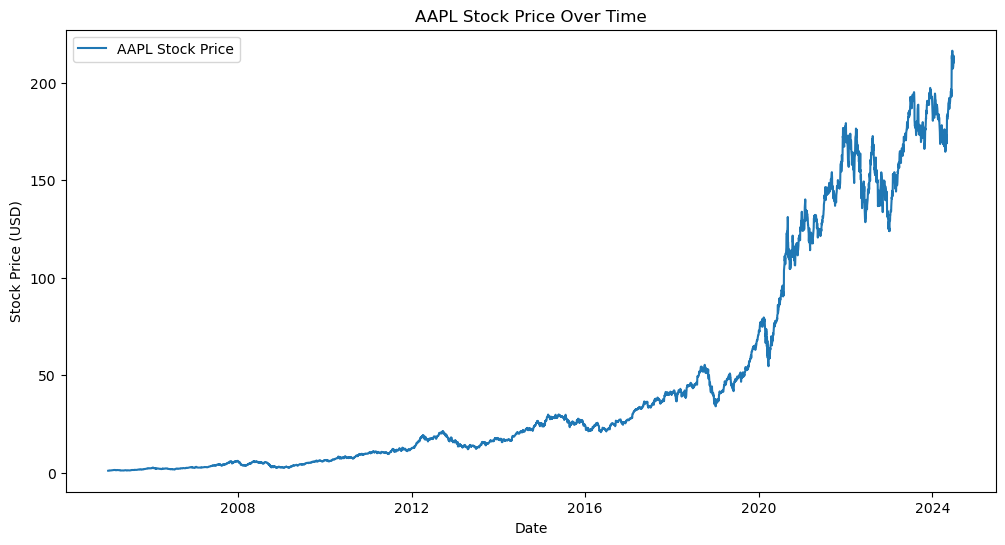

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='AAPL Stock Price')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [12]:
# include lagged variables for AAPL to capture historical dependencies
for lag in range(1, 8):  # Lags from 1 to 7 days
    stock_data[f'AAPL_lag_{lag}'] = stock_data['Close'].shift(lag)

# sdd log return as a feature
stock_data['AAPL_log_return'] = (stock_data['Close'] / stock_data['Close'].shift(1)).apply(lambda x: np.log(x))
stock_data.dropna(inplace=True)


In [13]:
features = stock_data.drop(columns=['Close'])  # all features except target
target = stock_data['Close']

# split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# ElasticNet with cross-validation for optimal alpha and l1_ratio parameters
elastic_net_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42))

# fit the model to the training data
elastic_net_model.fit(X_train, y_train)

coef = elastic_net_model.named_steps['elasticnetcv'].coef_

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coef})
feature_importance.sort_values(by='Coefficient', ascending=False, inplace=True)


print("Feature Importance:\n", feature_importance)


Feature Importance:
            Feature  Coefficient
0       AAPL_lag_1     7.663911
1       AAPL_lag_2     4.875206
2       AAPL_lag_3     3.157711
3       AAPL_lag_4     1.861252
4       AAPL_lag_5     1.017757
7  AAPL_log_return     0.323690
6       AAPL_lag_7     0.254986
5       AAPL_lag_6     0.183651


In [14]:

y_pred = elastic_net_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)


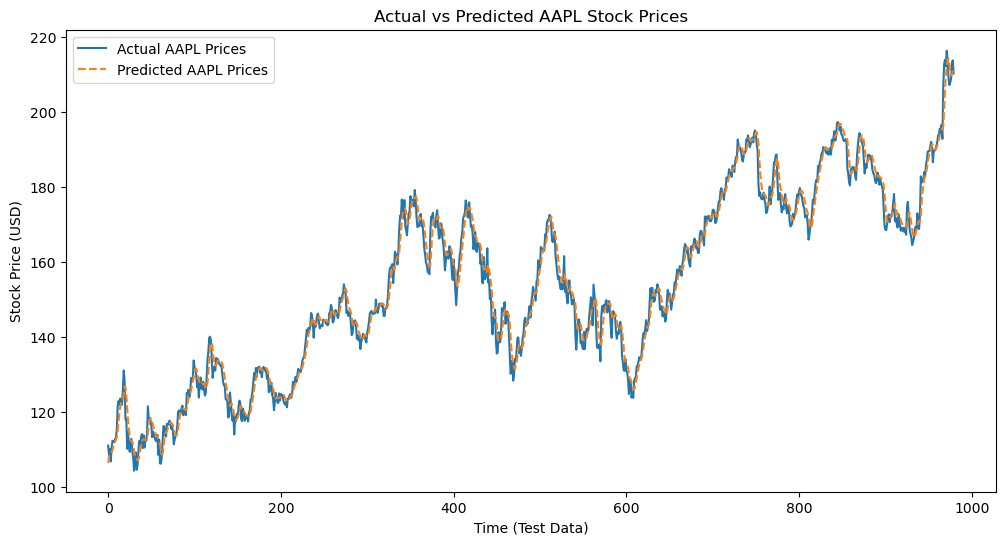

In [15]:
# Plotting actual vs predicted values to visualize forecast performance
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual AAPL Prices')
plt.plot(y_pred, label='Predicted AAPL Prices', linestyle='--')
plt.title('Actual vs Predicted AAPL Stock Prices')
plt.xlabel('Time (Test Data)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [16]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 9.293627328168482
Mean Absolute Error (MAE): 2.356219674431002
Root Mean Squared Error (RMSE): 3.0485451166365376
